<a href="https://colab.research.google.com/github/SoonhangJang/Korea_Lotto/blob/main/keras_lstm_lotto_968.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝 로또 번호 예측

- 딥러닝 로또 예측 번호 확인: https://animalface.site/lotto

- 동영상 설명: 유튜브 조코딩 채널(https://www.youtube.com/channel/UCQNE2JmbasNYbjGAcuBiRRg)

- 참고 문헌: 김태영님 블로그(https://tykimos.github.io/2020/01/25/keras_lstm_lotto_v895/)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install tensorflow-gpu==2.0.0-rc1
!pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 380.5MB 38kB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 501kB 37.2MB/s 
     |████████████████████████████████| 4.3MB 29.6MB/s 
     |████████████████████████████████| 2.9MB 5.4MB/s 
     |████████████████████████████████| 15.7MB 196kB/s 
ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.21.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing ins

In [1]:
import numpy as np

rows = np.loadtxt("./lotto(969).csv", delimiter=",")
row_count = len(rows)
print(row_count)

969


In [2]:
import numpy as np

# 당첨번호를 원핫인코딩벡터(ohbin)으로 변환
def numbers2ohbin(numbers):

    ohbin = np.zeros(45) #45개의 빈 칸을 만듬

    for i in range(6): #여섯개의 당첨번호에 대해서 반복함
        ohbin[int(numbers[i])-1] = 1 #로또번호가 1부터 시작하지만 벡터의 인덱스 시작은 0부터 시작하므로 1을 뺌
    
    return ohbin

# 원핫인코딩벡터(ohbin)를 번호로 변환
def ohbin2numbers(ohbin):

    numbers = []
    
    for i in range(len(ohbin)):
        if ohbin[i] == 1.0: # 1.0으로 설정되어 있으면 해당 번호를 반환값에 추가한다.
            numbers.append(i+1)
    
    return numbers

In [4]:
numbers = rows[:, 1:7]
ohbins = list(map(numbers2ohbin, numbers))

x_samples = ohbins[0:row_count-1]
y_samples = ohbins[1:row_count]

#원핫인코딩으로 표시
print("ohbins")
print("X[0]: " + str(x_samples[0]))
print("Y[0]: " + str(y_samples[0]))

#번호로 표시
print("numbers")
print("X[0]: " + str(ohbin2numbers(x_samples[0])))
print("Y[0]: " + str(ohbin2numbers(y_samples[0])))

ohbins
X[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Y[0]: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
numbers
X[0]: [10, 23, 29, 33, 37, 40]
Y[0]: [9, 13, 21, 25, 32, 42]


In [5]:
train_idx = (0, 800)
val_idx = (801, 900)
test_idx = (901, len(x_samples))

print("train: {0}, val: {1}, test: {2}".format(train_idx, val_idx, test_idx))

train: (0, 800), val: (801, 900), test: (901, 968)


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# 모델을 정의합니다.
model = keras.Sequential([
    keras.layers.LSTM(128, batch_input_shape=(1, 1, 45), return_sequences=False, stateful=True),
    keras.layers.Dense(45, activation='sigmoid')
])

# 모델을 컴파일합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
# 매 에포크마다 훈련과 검증의 손실 및 정확도를 기록하기 위한 변수
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# 최대 100번 에포크까지 수행
for epoch in range(100):

    model.reset_states() # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    batch_train_loss = []
    batch_train_acc = []
    
    for i in range(train_idx[0], train_idx[1]):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val_idx[0], val_idx[1]):

        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.test_on_batch(xs, ys) #배치만큼 모델에 입력하여 나온 답을 정답과 비교함
        
        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f} val acc {3:0.3f} loss {4:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss), np.mean(batch_val_acc), np.mean(batch_val_loss)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
epoch    0 train acc 0.861 loss 0.409 val acc 0.867 loss 0.399
epoch    1 train acc 0.867 loss 0.396 val acc 0.867 loss 0.398
epoch    2 train acc 0.867 loss 0.394 val acc 0.867 loss 0.398
epoch    3 train acc 0.867 loss 0.392 val acc 0.867 loss 0.399
epoch    4 train acc 0.867 loss 0.388 val acc 0.867 loss 0.401
epoch    5 train acc 0.867 loss 0.384 val acc 0.867 loss 0.404
epoch    6 train acc 0.867 loss 0.379 val acc 0.867 loss 0.407
epoch    7 train acc 0.867 loss 0.374 val acc 0.867 loss 0.410
epoch    8 train acc 0.867 loss 0.368 val acc 0.866 loss 0.413
epoch    9 train acc 0.867 loss 0.361 val acc 0.865 loss 0.416
epoch   10 train acc 0.867 loss 0.354 val acc 0.864 loss 0.420
epoch   11 train acc 0.868 loss 0.347 val acc 0.863 loss 0.424
epoch   12 train acc 0.868 loss 0.339 val acc 0.862 loss 0.429
epoch   13 train acc 0.870 loss 0.330 val acc 0.859 loss 0.434
epoch   14 train acc 0.8

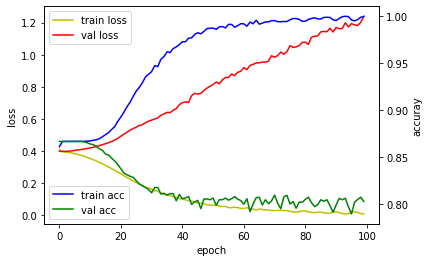

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label='train loss')
loss_ax.plot(val_loss, 'r', label='val loss')

acc_ax.plot(train_acc, 'b', label='train acc')
acc_ax.plot(val_acc, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [10]:
# 88회부터 지금까지 1등부터 5등까지 상금의 평균낸다.
mean_prize = [ np.mean(rows[87:, 8]),
           np.mean(rows[87:, 9]),
           np.mean(rows[87:, 10]),
           np.mean(rows[87:, 11]),
           np.mean(rows[87:, 12])]

print(mean_prize)   

[2433704365.5793653, 57197276.41609977, 1451163.336734694, 52801.56235827664, 5000.0]


In [11]:
# 등수와 상금을 반환함
# 순위에 오르지 못한 경우에는 등수가 0으로 반환함
def calc_reward(true_numbers, true_bonus, pred_numbers):

    count = 0

    for ps in pred_numbers:
        if ps in true_numbers:
            count += 1

    if count == 6:
        return 0, mean_prize[0]
    elif count == 5 and true_bonus in pred_numbers:
        return 1, mean_prize[1]
    elif count == 5:
        return 2, mean_prize[2]
    elif count == 4:
        return 3, mean_prize[3]
    elif count == 3:
        return 4, mean_prize[4]

    return 5, 0

In [14]:
def gen_numbers_from_probability(nums_prob):

    ball_box = []

    for n in range(45):
        ball_count = int(nums_prob[n] * 100 + 1)
        ball = np.full((ball_count), n+1) #1부터 시작
        ball_box += list(ball)

    selected_balls = []

    while True:
        
        if len(selected_balls) == 6:
            break
        
        ball_index = np.random.randint(len(ball_box), size=1)[0]
        ball = ball_box[ball_index]

        if ball not in selected_balls:
            selected_balls.append(ball)

    return selected_balls

In [15]:
train_total_reward = []
train_total_grade = np.zeros(6, dtype=int)

val_total_reward = []
val_total_grade = np.zeros(6, dtype=int)

test_total_reward = []
test_total_grade = np.zeros(6, dtype=int)

model.reset_states()

print('[No. ] 1st 2nd 3rd 4th 5th 6th Rewards')

for i in range(len(x_samples)):
    xs = x_samples[i].reshape(1, 1, 45)
    ys_pred = model.predict_on_batch(xs) # 모델의 출력값을 얻음
    
    sum_reward = 0
    sum_grade = np.zeros(6, dtype=int) # 6등까지 변수

    for n in range(10): # 10판 수행
        numbers = gen_numbers_from_probability(ys_pred[0])
        
        #i회차 입력 후 나온 출력을 i+1회차와 비교함
        grade, reward = calc_reward(rows[i+1,1:7], rows[i+1,7], numbers) 
        
        sum_reward += reward
        sum_grade[grade] += 1

        if i >= train_idx[0] and i < train_idx[1]:
            train_total_grade[grade] += 1
        elif i >= val_idx[0] and i < val_idx[1]:
            val_total_grade[grade] += 1
        elif i >= test_idx[0] and i < test_idx[1]:
            val_total_grade[grade] += 1
    
    if i >= train_idx[0] and i < train_idx[1]:
        train_total_reward.append(sum_reward)
    elif i >= val_idx[0] and i < val_idx[1]:
        val_total_reward.append(sum_reward)
    elif i >= test_idx[0] and i < test_idx[1]:
        test_total_reward.append(sum_reward)
                        
    print('[{0:4d}] {1:3d} {2:3d} {3:3d} {4:3d} {5:3d} {6:3d} {7:15,d}'.format(i+1, sum_grade[0], sum_grade[1], sum_grade[2], sum_grade[3], sum_grade[4], sum_grade[5], int(sum_reward)))

print('Total') 
print('==========')    
print('Train {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(train_total_grade[0], train_total_grade[1], train_total_grade[2], train_total_grade[3], train_total_grade[4], train_total_grade[5], int(sum(train_total_reward))))
print('Val   {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(val_total_grade[0], val_total_grade[1], val_total_grade[2], val_total_grade[3], val_total_grade[4], val_total_grade[5], int(sum(val_total_reward))))
print('Test  {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(test_total_grade[0], test_total_grade[1], test_total_grade[2], test_total_grade[3], test_total_grade[4], test_total_grade[5], int(sum(test_total_reward))))
print('==========')    

[No. ] 1st 2nd 3rd 4th 5th 6th Rewards
[   1]   3   0   4   3   0   0   7,307,076,154
[   2]   2   0   7   1   0   0   4,877,619,676
[   3]   3   0   5   2   0   0   7,308,474,516
[   4]   3   0   6   1   0   0   7,309,872,878
[   5]   1   0   8   1   0   0   2,445,366,473
[   6]   3   0   4   2   1   0   7,307,028,353
[   7]   2   1   5   2   0   0   4,931,967,427
[   8]   5   0   4   1   0   0  12,174,379,282
[   9]   2   0   6   2   0   0   4,876,221,314
[  10]   5   0   3   1   1   0  12,172,933,119
[  11]   3   0   7   0   0   0   7,311,271,240
[  12]   4   0   5   0   1   0   9,742,078,279
[  13]   2   0   5   3   0   0   4,874,822,952
[  14]   3   0   4   3   0   0   7,307,076,154
[  15]   4   0   5   1   0   0   9,742,126,080
[  16]   2   0   7   1   0   0   4,877,619,676
[  17]   4   0   5   1   0   0   9,742,126,080
[  18]   1   0   7   2   0   0   2,443,968,112
[  19]   1   0   6   2   1   0   2,442,521,948
[  20]   0   0   6   3   1   0       8,870,384
[  21]   4   0   4   

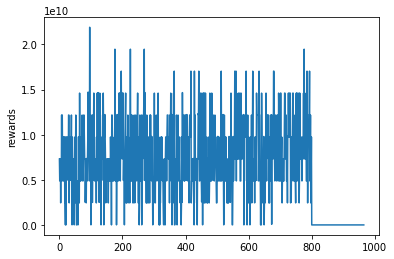

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

total_reward = train_total_reward + val_total_reward + test_total_reward

plt.plot(total_reward)
plt.ylabel('rewards')
plt.show()

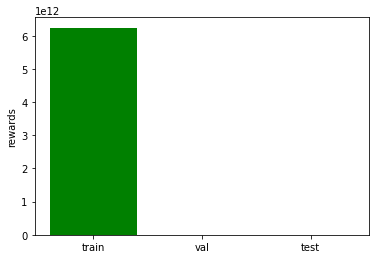

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

rewards = [sum(train_total_reward), sum(val_total_reward), sum(test_total_reward)]

class_color=['green', 'blue', 'red']

plt.bar(['train', 'val', 'test'], rewards, color=class_color)
plt.ylabel('rewards')
plt.show()

In [18]:
# 최대 100번 에포크까지 수행
for epoch in range(100):

    model.reset_states() # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    for i in range(len(x_samples)):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss)))  

epoch    0 train acc 0.979 loss 0.115
epoch    1 train acc 0.967 loss 0.148
epoch    2 train acc 0.965 loss 0.149
epoch    3 train acc 0.965 loss 0.144
epoch    4 train acc 0.966 loss 0.137
epoch    5 train acc 0.967 loss 0.131
epoch    6 train acc 0.968 loss 0.126
epoch    7 train acc 0.968 loss 0.121
epoch    8 train acc 0.969 loss 0.116
epoch    9 train acc 0.970 loss 0.112
epoch   10 train acc 0.971 loss 0.108
epoch   11 train acc 0.971 loss 0.105
epoch   12 train acc 0.972 loss 0.101
epoch   13 train acc 0.973 loss 0.098
epoch   14 train acc 0.974 loss 0.095
epoch   15 train acc 0.974 loss 0.093
epoch   16 train acc 0.975 loss 0.090
epoch   17 train acc 0.975 loss 0.088
epoch   18 train acc 0.976 loss 0.085
epoch   19 train acc 0.977 loss 0.083
epoch   20 train acc 0.977 loss 0.081
epoch   21 train acc 0.978 loss 0.079
epoch   22 train acc 0.978 loss 0.077
epoch   23 train acc 0.979 loss 0.076
epoch   24 train acc 0.979 loss 0.074
epoch   25 train acc 0.980 loss 0.072
epoch   26 t

In [60]:
# 마지막 회차까지 학습한 모델로 다음 회차 추론

print('receive numbers')

xs = x_samples[-1].reshape(1, 1, 45)

ys_pred = model.predict_on_batch(xs)

list_numbers = []

for n in range(5):
    numbers = gen_numbers_from_probability(ys_pred[0])
    numbers.sort()
    print('{0} : {1}'.format(n, numbers))
    list_numbers.append(numbers)

receive numbers
0 : [2, 3, 5, 19, 25, 34]
1 : [3, 17, 19, 25, 34, 36]
2 : [3, 19, 25, 29, 34, 35]
3 : [12, 19, 24, 25, 28, 43]
4 : [2, 5, 19, 25, 29, 34]


- 딥러닝 로또 예측 번호 확인: https://animalface.site/lotto

- 동영상 설명: 유튜브 조코딩 채널(https://www.youtube.com/channel/UCQNE2JmbasNYbjGAcuBiRRg)

- 참고 문헌: 김태영님 블로그(https://tykimos.github.io/2020/01/25/keras_lstm_lotto_v895/)